In [1]:
%matplotlib inline

# Calculating changes in the degree of glaciation of each catchment

In [2]:
# This notebook calculates the changes in the degree of glaciation of each catchment
# We read glacier outlines from Hannesdottir et al, for 1890-2019, and calculate the percentage and total km2 of glaciation for each catchment
# Glacier outlines are from:
# Hannesdóttir, H., Sigurðsson, O., Þrastarson, R. H., Guðmundsson, S., Belart, J. M. C., Pálsson, F., Magnússon, E., Víkingsson, S., Kaldal, I., and Jóhannesson, T.: A national glacier inventory and variations in glacier extent in Iceland from the Little Ice Age maximum to 2019, Jökull, https://doi.org/10.33799/jokull2020.70.001, 2020.

In [3]:
import geopandas as gpd
import pandas as pds
from pathlib import Path
import os
import geopandas as gpd
from shapely.geometry import Polygon, mapping
import matplotlib.pyplot as plt
import numpy as np
pds.options.display.max_rows = 999

# Define functions

In [4]:
# Define functions used
def linestring_to_polygon(gdf,orig_gdf):
    # This function converts glacier outline linestrings to polygons
    # Thanks to Carlos Encisco, https://stackoverflow.com/questions/2964751/how-to-convert-a-geos-multilinestring-to-polygon
    all_coords = mapping(gdf.geometry)['coordinates']
    lats = [x[1] for x in all_coords]
    lons = [x[0] for x in all_coords]
    polyg = Polygon(zip(lons, lats))
    return gpd.GeoDataFrame(index=[0], crs=orig_gdf.crs, geometry=[polyg])

def replace_nans_with_zeros(dataframe):
    df = dataframe.copy()
    # This function replaces nan values with zeros where appropriate.
    for i in df.index:
        if i in [24,29]: # An error in the dataset: Data is missing in 2014 for Þrándajökull glacier. Safe to interpolate between 2000 and 2017.
            continue
        elif i in [34,106]: # There is data for Drangajökull glacier and Vatnajökull glacier in 1945 - So we can set 0 for 1945 onwards.
            df.loc[i][[1945,1970,2000,2014,2017,2019]] = 0
            continue
        # If there is a valid value in 1890:
        if not np.isnan(df.loc[i][1890]):
            # If there is a nan in 2000:
            if np.isnan(df.loc[i][2000]):
                df.loc[i][[2000,2014,2017,2019]] = 0
                print('2000 onwards: ID %s' %i)
            elif np.isnan(df.loc[i][2014]):
                print('2014 onwards: ID %s' %i)
                df.loc[i][[2014,2017,2019]] = 0
            elif np.isnan(df.loc[i][2017]):
                print('2017 onwards: ID %s' %i)
                df.loc[i][[2017,2019]] = 0
            elif np.isnan(df.loc[i][2019]):
                print('2019 onwards: ID %s' %i)
                df.loc[i][[2019]] = 0
    return(df)

def interpolate(results_dataframe):
    df = results_dataframe.copy()
    years = list(range(1890, 2020))
    df = df.reindex(columns=years)
    df.interpolate(method='linear', axis=1, inplace=True)
    return(df)

# Read files

In [5]:
# Read watersheds and gauges shapefiles
watersheds = gpd.read_file(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\lamah_ice\A_basins_total_upstrm\3_shapefiles\Basins_A.shp')
watersheds.index = watersheds['id']
watersheds = watersheds.sort_index()

gauges = gpd.read_file(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\lamah_ice\D_gauges\3_shapefiles\gauges.shp')
gauges.index = gauges['id']
gauges = gauges.drop(columns=['id'])
gauges = gauges.sort_index()

# Define the paths to the glacier outline shapefiles
glacier_filenames = dict()
path = Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\glacier_outline_1890_2019_hh_Aug2021\jökla-útlínur")
for year in [1890,1945,1970,2000,2014,2017,2019]: #2011,2012 #2007,2008 2010,
    if year in [1970,2000]:
        fname = '%ss_glacier_outlines.shp' % year
    else:
        fname = '%s_glacier_outlines.shp' % year
    glacier_filenames[year] = os.path.join(path,fname)
# Note: Years 1890, 2000, 2014, 2017 and 2019 contain all glaciers. 1945 and 1970 only contain the largest glaciers.

# We create a pandas dataframe to insert results
results_percentage = pds.DataFrame(index=watersheds.index)
results_km2 = pds.DataFrame(index=watersheds.index)

# Perform calculations

In [6]:
# Loop over each year and calculate the glacierized area and percentage of catchment under glacier
for year, filename in glacier_filenames.items():
    print(year)
    # Read in the glacier geodataframe for this year
    glaciers = gpd.read_file(filename)
    # We select only the lines that are classified as glacier outlines
    glacier_bounds = glaciers[glaciers['catagory']=='glac_bound']
    polygon_geoms = []
    for i in glacier_bounds.index:
        # Blöndujökull Glacier (á Hornströndum) (i=559): The geometry is broken for 1890
        if i == 559 and year == 1890:
            glacier_bounds = glacier_bounds.drop(i)
            continue
        # Some glacier bounds have invalid geometries (nonetype)
        # We convert the linestring to polygon if the geometry is valid
        # If not, we remove the corresponding row in glacier_bounds
        # This actually just happens for id. 824 in 2000 
        if glacier_bounds.loc[i].geometry:
            polygon_geoms.append(linestring_to_polygon(glacier_bounds.loc[i],glacier_bounds).values[0][0])
        else:
            glacier_bounds = glacier_bounds.drop(i)
            print('Glacier bound id. %s dropped for %s' %(i,year))
            
    # Update the geometry of glacier_bounds with the corrected geometry
    glacier_bounds = glacier_bounds.set_geometry(polygon_geoms) 
    glaciers = glacier_bounds
    
    # Calculate the intersection between the catchments and glaciers
    catchments_glaciers = gpd.overlay(watersheds, glaciers, how='intersection')

    # Calculate the intersection area between each catchment and glacier
    catchments_glaciers['intersection_area'] = catchments_glaciers.geometry.area 

    # Calculate the total area of each catchment
    watersheds['catchment_area'] = watersheds.geometry.area

    # Calculate the total glacier area within each catchment
    grouped = catchments_glaciers.groupby('id')['intersection_area'].sum()

    # Sort both dataframes so that the percentage calculation is correct
    grouped = grouped.sort_index() 
    watersheds = watersheds.sort_index()
    watersheds['glacier_area'] = grouped
    
    # Calculate the percentage of area of each catchment covered by glaciers
    watersheds['glacier_percentage'] = (watersheds['glacier_area'] / watersheds['catchment_area']) * 100
    results_percentage[year] = watersheds['glacier_percentage']
    results_km2[year] = watersheds['glacier_area']/1e6

1890
1945
1970
2000
Glacier bound id. 824 dropped for 2000
2014
2017
2019


In [7]:
# Small glaciers in North-Iceland are not represented in the outlines in 1945 or 1970 for the following gauges:
listi = ['V321','V51','V517','V92']
app = []
for l in listi:
    app.append(gauges[gauges['V_no'] == l].index[0]) #,'V51','V517','V92']]

# We set the corresponding glacier percentages in the results dataframe as nans    
for i in app:
    results_km2.loc[i, [1945, 1970]] = np.nan
    results_percentage.loc[i, [1945, 1970]] = np.nan
    
# We set the glacier percentage and area for watershed id. 26 as 0 since the percentage is extremely low
results_km2.loc[26] = np.nan
results_percentage.loc[26] = np.nan

In [8]:
# The glacial coverage is provided for years 1890, 1945, 1970, 2000, 2014, 2017 and 2019
# Years 1890, 2000, 2014, 2017 and 2019 contain data for all the glaciers in Iceland. 
# Years 1945 and 1970 only contain the largest glaciers, so for these years, the dataframes have Nan values
# We need to update our calculations: If there's a NaN for years where all glaciers are covered, it's supposed to be a zero
# This applies to all catchment IDs except 24 and 29 (For some reason, the 2014 year does not contain data for Þrándajökull)

# So if there is a number in 1890 and a nan in years 2000, 2014, 2017 or 2019:
# It means that the glacier has disappeared and area estimates should be zero from there on.
# So we apply the replace_nans_with_zeros function
final_results_km2 = replace_nans_with_zeros(results_km2)
final_results_percentage = replace_nans_with_zeros(results_percentage)

2014 onwards: ID 1
2000 onwards: ID 8
2014 onwards: ID 1
2000 onwards: ID 8


In [9]:
# We set the glacier percentage and area for watershed id. 26 as 0 since the percentage is extremely low
results_km2.loc[26] = np.nan
results_percentage.loc[26] = np.nan

# Perform interpolation between years with valid data:

In [10]:
# The glacial coverage is provided for years 1890, 1945, 1970, 2000, 2014, 2017 and 2019
# Years 1890, 2000, 2014, 2017 and 2019 contain data for all the glaciers in Iceland. 
# Years 1945 and 1970 only contain the largest glaciers, so for these years, the dataframes have Nan values
# We need to update our calculations: If there's a NaN for years where all glaciers are covered, it's supposed to be a zero
# This applies to all catchment IDs except 24 and 29 (For some reason, the 2014 year does not contain data for Þrándajökull)

# So if there is a number in 1890 and a nan in years 2000, 2014, 2017 or 2019:
# It means that the glacier has disappeared and area estimates should be zero from there on.

In [11]:
interp_final_results_km2 = interpolate(final_results_km2)
interp_final_results_percentage = interpolate(final_results_percentage)

# Save as .csv

In [12]:
savepath = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\2_timeseries\annual\glaciated_area_km2_final.csv") 
interp_final_results_km2.round(3).to_csv(savepath)
savepath = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\2_timeseries\annual\glaciated_area_percentage_final.csv")
interp_final_results_percentage.round(3).to_csv(savepath)

# Print statistics

In [13]:
# Eliminate the splitted gauges
interp_final_results_percentage = interp_final_results_percentage[:-4]
interp_final_results_km2 = interp_final_results_km2[:-4]
# How many catchments are partly covered by glaciers in 1950?
len(interp_final_results_percentage[interp_final_results_percentage[1950]>0].dropna())

63

In [14]:
# How many catchments are partly covered by glaciers in 1890?
len(interp_final_results_percentage[interp_final_results_percentage[1890]>0].dropna())

65

In [15]:
# How many catchments are partly covered by glaciers in 2019?
len(interp_final_results_percentage[interp_final_results_percentage[2019]>0][2019].dropna())

61

# Stats for percent glaciation - 1950 to 2019

In [16]:
# We skip all catchments with less than 2% glaciation in 1950
glacier_data = interp_final_results_percentage[interp_final_results_percentage[1950]>2].transpose()

startyear = '1950'

# Subset the DataFrame to include only years from 1950 to 2019
glacier_data_1950_2019 = glacier_data.loc[startyear:'2019']

# Calculate the difference in glaciated area between 1950 and 2019 for each watershed
glacier_area_diff = glacier_data_1950_2019.iloc[-1] - glacier_data_1950_2019.iloc[0]

# Calculate the mean change in glaciated area
mean_glacier_area_diff = glacier_area_diff.mean()

print("Out of the %s catchments with more than 2%% glaciation:" % len(interp_final_results_percentage[interp_final_results_percentage[1950]>2]))
print("The mean change in glaciated area from %s to 2019 is:" % startyear, mean_glacier_area_diff)
print("The median change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.median())
print("The max change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.max())
print("The min change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.min())
print(' ')
print("The mean percent glaciated area in %s is:" % startyear, glacier_data_1950_2019.iloc[0].mean())
print("The mean percent glaciated area in 2019 is:", glacier_data_1950_2019.iloc[-1].mean())

Out of the 55 catchments with more than 2% glaciation:
The mean change in glaciated area from 1950 to 2019 is: -3.0536051891280294
The median change in glaciated area from 1950 to 2019 is: -2.6718206088631717
The max change in glaciated area from 1950 to 2019 is: -0.20824364809465745
The min change in glaciated area from 1950 to 2019 is: -8.940828544464978
 
The mean percent glaciated area in 1950 is: 27.237320233304064
The mean percent glaciated area in 2019 is: 24.183715044176022


In [17]:
# Where does the max and min occur?
glacier_area_diff.idxmin()

48

In [18]:
glacier_area_diff.loc[48]

-8.940828544464978

In [19]:
glacier_area_diff.loc[103]

-2.0695659258466996

# Stats for glacier area in km2

In [20]:
# We skip all catchments with less than 2% glaciation in 1950
glacier_data = interp_final_results_km2[interp_final_results_percentage[1950]>2].transpose()

startyear = '1950'

# Subset the DataFrame to include only years from 1950 to 2019
glacier_data_1950_2019 = glacier_data.loc[startyear:'2019']

# Calculate the difference in glaciated area between 1950 and 2019 for each watershed
glacier_area_diff = glacier_data_1950_2019.iloc[-1] - glacier_data_1950_2019.iloc[0]

# Calculate the mean change in glaciated area
mean_glacier_area_diff = glacier_area_diff.mean()
print("Out of the %s catchments with more than 2%% glaciation:" % len(interp_final_results_percentage[interp_final_results_percentage[1950]>2]))
print("The mean change in glaciated area from %s to 2019 is:" % startyear, mean_glacier_area_diff)
print("The median change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.median())
print("The max change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.max())
print("The min change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.min())
print(' ')
print("The mean percent glaciated area in %s is:" % startyear, glacier_data_1950_2019.iloc[0].mean())
print("The mean percent glaciated area in 2019 is:", glacier_data_1950_2019.iloc[-1].mean())

Out of the 55 catchments with more than 2% glaciation:
The mean change in glaciated area from 1950 to 2019 is: -34.83100904672141
The median change in glaciated area from 1950 to 2019 is: -28.41027924061632
The max change in glaciated area from 1950 to 2019 is: -0.2381896706404063
The min change in glaciated area from 1950 to 2019 is: -137.1809433726262
 
The mean percent glaciated area in 1950 is: 365.4290461440551
The mean percent glaciated area in 2019 is: 330.5980370973337


In [21]:
glacier_area_diff.idxmin()

103

In [23]:
glacier_area_diff.loc[103]

-137.1809433726262

In [24]:
glacier_area_diff.loc[48]

-27.033063806615573

# Check stats for 1890

# Percent

In [25]:
# Test stats for 1890:
# We skip all catchments with less than 2% glaciation in 1950
glacier_data = interp_final_results_percentage[interp_final_results_percentage[1950]>2].transpose()

startyear = '1890'

# Subset the DataFrame to include only years from 1950 to 2019
glacier_data_1950_2019 = glacier_data.loc[startyear:'2019']

# Calculate the difference in glaciated area between 1950 and 2019 for each watershed
glacier_area_diff = glacier_data_1950_2019.iloc[-1] - glacier_data_1950_2019.iloc[0]

# Calculate the mean change in glaciated area
mean_glacier_area_diff = glacier_area_diff.mean()

print("Out of the %s catchments with more than 2%% glaciation:" % len(interp_final_results_percentage[interp_final_results_percentage[int(startyear)]>2]))
print("The mean change in glaciated area from %s to 2019 is:" % startyear, mean_glacier_area_diff)
print("The median change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.median())
print("The max change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.max())
print("The min change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.min())
print(' ')
print("The mean percent glaciated area in %s is:" % startyear, glacier_data_1950_2019.iloc[0].mean())
print("The mean percent glaciated area in 2019 is:", glacier_data_1950_2019.iloc[-1].mean())

Out of the 56 catchments with more than 2% glaciation:
The mean change in glaciated area from 1890 to 2019 is: -5.64346797951723
The median change in glaciated area from 1890 to 2019 is: -4.184394006573697
The max change in glaciated area from 1890 to 2019 is: -0.22643723486738843
The min change in glaciated area from 1890 to 2019 is: -18.640184691798154
 
The mean percent glaciated area in 1890 is: 29.82718302369326
The mean percent glaciated area in 2019 is: 24.183715044176022


In [26]:
# Where does the max and min occur?
glacier_area_diff.idxmin()

78

In [27]:
glacier_area_diff.loc[78]

-18.640184691798154

In [28]:
glacier_area_diff.loc[103]

-3.459179506733374

# Area

In [29]:
# We skip all catchments with less than 2% glaciation in 1950
glacier_data = interp_final_results_km2[interp_final_results_percentage[1950]>2].transpose()

startyear = '1890'

# Subset the DataFrame to include only years from 1950 to 2019
glacier_data_1950_2019 = glacier_data.loc[startyear:'2019']

# Calculate the difference in glaciated area between 1950 and 2019 for each watershed
glacier_area_diff = glacier_data_1950_2019.iloc[-1] - glacier_data_1950_2019.iloc[0]

# Calculate the mean change in glaciated area
mean_glacier_area_diff = glacier_area_diff.mean()
print("Out of the %s catchments with more than 2%% glaciation:" % len(interp_final_results_percentage[interp_final_results_percentage[int(startyear)]>2]))
print("The mean change in glaciated area from %s to 2019 is:" % startyear, mean_glacier_area_diff)
print("The median change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.median())
print("The max change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.max())
print("The min change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.min())
print(' ')
print("The mean percent glaciated area in %s is:" % startyear, glacier_data_1950_2019.iloc[0].mean())
print("The mean percent glaciated area in 2019 is:", glacier_data_1950_2019.iloc[-1].mean())

Out of the 56 catchments with more than 2% glaciation:
The mean change in glaciated area from 1890 to 2019 is: -63.282729661981584
The median change in glaciated area from 1890 to 2019 is: -43.93490180778474
The max change in glaciated area from 1890 to 2019 is: -0.6029308022856368
The min change in glaciated area from 1890 to 2019 is: -229.29132244714492
 
The mean percent glaciated area in 1890 is: 393.8807667593154
The mean percent glaciated area in 2019 is: 330.5980370973337


In [30]:
# Where does the max and min occur?
glacier_area_diff.idxmin()

103

In [31]:
glacier_area_diff.loc[103]

-229.29132244714492

In [32]:
glacier_area_diff.loc[78]

-3.642599393280813

# Save timeseries as .csv for each catchment

In [ ]:
# This is done here: https://github.com/hhelgason/LamaH-Ice/blob/main/timeseries/finalize_modis_and_glacier_timeseries.ipynb

# Prepare calculations of topographic glacier attributes:
# Clip the watersheds by the 2019 glacier outlines:

In [32]:
# We re-use the code from above:
year = 2019
filename = glacier_filenames[year]
# Read in the glacier geodataframe for this year
glaciers = gpd.read_file(filename)
# We select only the lines that are classified as glacier outlines
glacier_bounds = glaciers[glaciers['catagory']=='glac_bound']
polygon_geoms = []
for i in glacier_bounds.index:
    # Blöndujökull á Hornströndum (i=559): Geometrían er biluð fyrir 1890
    if i == 559 and year == 1890:
        glacier_bounds = glacier_bounds.drop(i)
        continue
    # Some glacier bounds have invalid geometries (nonetype)
    # We convert the linestring to polygon if the geometry is valid
    # If not, we remove the corresponding row in glacier_bounds
    # This actually just happens for id. 824 in 2000 
    if glacier_bounds.loc[i].geometry:
        polygon_geoms.append(linestring_to_polygon(glacier_bounds.loc[i],glacier_bounds).values[0][0])
    else:
        glacier_bounds = glacier_bounds.drop(i)
        print('Glacier bound id. %s dropped for %s' %(i,year))

# Update the geometry of glacier_bounds with the corrected geometry
glacier_bounds = glacier_bounds.set_geometry(polygon_geoms) 
glaciers = glacier_bounds

In [33]:
# Calculate the intersection between the catchments and glaciers
catchments_glaciers = gpd.overlay(watersheds, glaciers, how='intersection')

# Group the catchment-glacier polygons by catchment ID
grouped = catchments_glaciers.groupby('id')['geometry'].agg(lambda x: x.unary_union)

# Create a new GeoDataFrame with catchment ID and merged catchment geometry
merged_catchments = gpd.GeoDataFrame(geometry=grouped.values, crs=watersheds.crs)
merged_catchments['id'] = grouped.index

merged_catchments.index = merged_catchments['id']
merged_catchments = merged_catchments.drop(columns=['id']) #to_file('merged_catchments.shp')
# Save the merged catchments to a shapefile
savepath = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\3_shapefiles\glaciers_in_catchments.shp")
merged_catchments.to_file(savepath)

<Axes: >

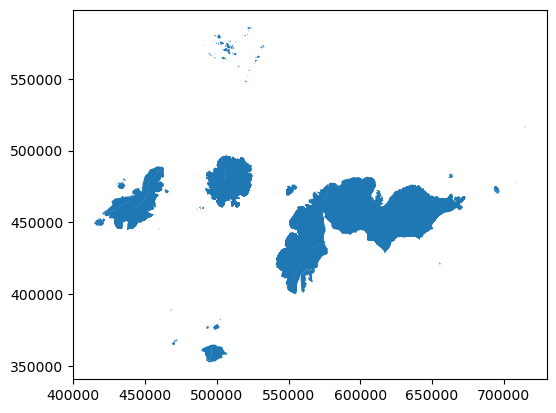

In [34]:
merged_catchments.plot() #.loc[78].geometry

# Create a watersheds shapefile where we exclude glaciers

In [19]:
# The shapefile is used in the modis snow cover calculations, https://github.com/hhelgason/LamaH-Ice/blob/main/timeseries/modis_fsca_to_watersheds.py

In [35]:
# Calculate the intersection between the catchments and glaciers
catchments_glaciers = gpd.overlay(watersheds, glaciers, how='intersection')

# Group the catchment-glacier polygons by catchment ID
grouped = catchments_glaciers.groupby('id')['geometry'].agg(lambda x: x.unary_union)

# Create a new GeoDataFrame with catchment ID and merged catchment geometry
merged_catchments = gpd.GeoDataFrame(geometry=grouped.values, crs=watersheds.crs)
merged_catchments['id'] = grouped.index
merged_catchments.index = merged_catchments['id']
merged_catchments = merged_catchments.drop(columns=['id'])

# Calculate the difference between the merged catchments and the original watersheds
non_glacier_watersheds = watersheds.geometry.difference(merged_catchments.geometry.unary_union)

# Create a new GeoDataFrame with the non-glacier watersheds
non_glacier_watersheds_gdf = gpd.GeoDataFrame(geometry=non_glacier_watersheds, crs=watersheds.crs)

# Save the non-glacier watersheds to a shapefile
path_to_save = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\3_shapefiles\non_glacier_watersheds.shp")
non_glacier_watersheds_gdf.to_file(path_to_save)

C:\Users\hordurbhe\AppData\Local\anaconda3_\envs\lamah_py311\Lib\site-packages\shapely\set_operations.py:77: RuntimeWarning: divide by zero encountered in difference
  return lib.difference(a, b, **kwargs)


<Axes: >

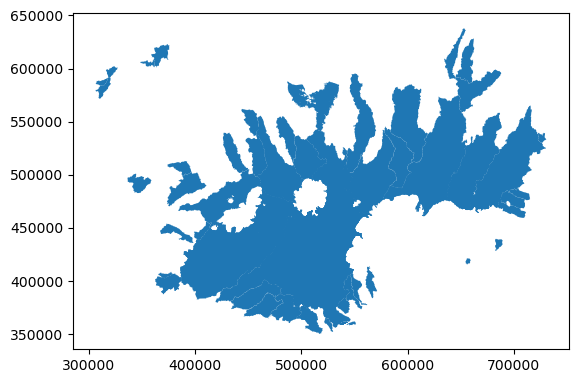

In [36]:
non_glacier_watersheds_gdf.plot()

In [37]:
# Check which polygons are valid
path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\3_shapefiles\non_glacier_watersheds.shp")
gdf = gpd.read_file(path)
gdf = gdf.set_index('id')
valid_polygons = gdf.geometry.is_valid
valid_polygons

id
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
30      True
31      True
32      True
33      True
34      True
35      True
36      True
37      True
38      True
39      True
40      True
41      True
42      True
43      True
44      True
45      True
46      True
47      True
48      True
49      True
50      True
51      True
52      True
53      True
54      True
55      True
56      True
57      True
58      True
59      True
60      True
61      True
62      True
63      True
64      True
65      True
66      True
67      True
68      True
69      True
70      True
71      True
72      True
73      True
74      True
75      True
76      True
77      T

In [38]:
# Check which polygons are valid
path = Path(r"C:/Users/hordurbhe/Dropbox/UW/lamah_ice/lamah_ice/A_basins_total_upstrm/3_shapefiles/glaciers_in_catchments.shp")
gdf = gpd.read_file(path)
gdf = gdf.set_index('id')
valid_polygons = gdf.geometry.is_valid
valid_polygons

id
2       True
3       True
4       True
6       True
7       True
9       True
11      True
14      True
21      True
24      True
29      True
31      True
32      True
33      True
35      True
36      True
37      True
38      True
40      True
41      True
42      True
43      True
44      True
45      True
46      True
47      True
48      True
49      True
51      True
52      True
53      True
54      True
55      True
56      True
57      True
59      True
60      True
62      True
66      True
71      True
73      True
74      True
75      True
76      True
77      True
78      True
79      True
81      True
86      True
87      True
88      True
89      True
93      True
95      True
98      True
99      True
100     True
101     True
102     True
103     True
104     True
990     True
1010    True
9900    True
dtype: bool